In [1]:
using Pkg
using WebIO
using PyPlot
using Eirene
using PersistenceImage
using MAT
using Glob

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-13031977173223221699\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-14372173687697370065\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-13031977173223221699\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

#### TODO:
- Parse well number from filename and sort
- Add colorbar to heatmap
- Change tick labels to well name, e.g. 'Well 01'
- For each well, find the 'closest' well by Wasserstein distance
- For some randonly selected wells, visually inspect if the barcodes and point clouds look similar
- Also, calculate persistence imgs for all wells and compute Euclidean distance between persistance imgs
    - $\frac{1}{nx \times ny} \sum_{x}\sum_{y} |I_1(x,y) - I_2(x,y)|^2$

In [6]:
filelist = glob("EGF(E6)w*.mat","experimental-data")
sz = size(filelist)[1];
eirenepreparray = [];
for i in 1:sz
    allvariables = matread(filelist[i]);
    allx = allvariables["storeX"];
    ally = allvariables["storeY"];
    #velocity not relevant yet
    #allxvel = allvariables["storevelX"]);
    #allyvel = allvariables["storevelY"]);
    timesteplastx = allx[1:end,size(allx)[2]];
    timesteplasty = ally[1:end,size(ally)[2]];
    timesteplastx = filter!(!(isnan),timesteplastx);
    timesteplasty = filter!(!(isnan),timesteplasty);
    positiontimelast = hcat(timesteplastx, timesteplasty);
    positiontimelast = transpose(positiontimelast);
    push!(eirenepreparray, positiontimelast);
end

In [20]:
persist_diagarray = [];
barcodes_array = []
for j in 1:sz
    pers_diag = eirene(eirenepreparray[j], model="pc", maxdim = 1);
    push!(persist_diagarray, pers_diag);
    push!(barcodes_array, barcode(pers_diag));
end

In [24]:
wassmatrix = Array{Float64}(undef, sz, sz);
for rows in 1:sz
    for cols in 1:sz
        wassmatrix[rows,cols] = wasserstein_distance(barcodes_array[rows], barcodes_array[cols], q=2, p=2);
    end
end

Example plotting code from Python

```python
# Note: For images normalize to 1.0 or 255 (0-255)
plt.figure(figsize=(8,6), dpi=300)
plt.imshow(img, cmap='gray')
plt.colorbar()
ax = plt.gca()
ax.set_xticklabels([array_of_labels])
plt.savefig("myfig.eps")
```

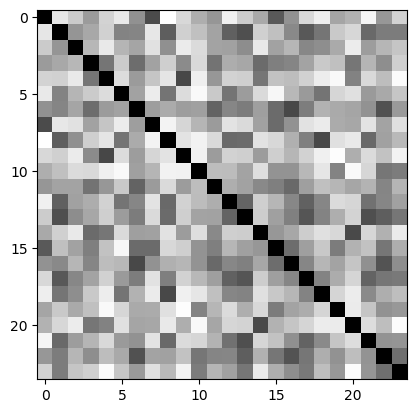

PyObject <matplotlib.image.AxesImage object at 0x00000000390BDF98>

In [34]:
max_coord = maximum(wassmatrix);
wassmatrix = wassmatrix/max_coord;
wassmatrix = wassmatrix * 100;
imshow(wassmatrix, cmap="gray")

0